# Marginal Learning in Discrete Markov Networks

In this notebook, we show an example for learning the parameters (potentials) of a Factor Graph or Markov Network given the data and its corresponding marginals.

In the examples, we will generate some data from given models and perform out of clique inference for certain queries.

In [1]:
from pgmpy.models import FactorGraph
from pgmpy.factors.discrete import DiscreteFactor
import numpy as np
import networkx as nx
import pandas as pd
from pgmpy.estimators import MirrorDescentEstimator
from pgmpy.inference.ExactInference import BeliefPropagation
from pgmpy.factors import FactorDict
from matplotlib import pyplot as plt

### Step 1: Load the `games` data and form a `FactorGraph`

In [2]:
games = pd.read_csv("games.csv")
# Define a "win" to include ties for the home team.
games["homeWin"] = (games.homeFinalScore >= games.visitorFinalScore).map(
    lambda x: "win" if x else "loss"
)
TEAMS = sorted(set(games.homeTeamAbbr).union(set(games.visitorTeamAbbr)))
df = games[["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]]
df.head()

,homeTeamAbbr,visitorTeamAbbr,homeWin
0,KC,DET,loss
1,MIN,TB,loss
2,NO,TEN,win
3,ATL,CAR,win
4,BAL,HOU,win


In [3]:
G = FactorGraph()
nodes = ["homeTeamAbbr", "visitorTeamAbbr", "homeWin"]
state_names = {
    "homeTeamAbbr": TEAMS,
    "visitorTeamAbbr": TEAMS,
    "homeWin": ["loss", "win"],
}
factors = [
    # One-way marginals.
    DiscreteFactor(
        variables=["homeTeamAbbr"],
        cardinality=[32],
        values=np.zeros(32),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr"],
        cardinality=[32],
        values=np.zeros(32),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["homeWin"],
        cardinality=[2],
        values=np.zeros(2),
        state_names=state_names,
    ),
    # Two-way marginals.
    DiscreteFactor(
        variables=["homeTeamAbbr", "homeWin"],
        cardinality=[32, 2],
        values=np.zeros((32, 2)),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr", "homeWin"],
        cardinality=[32, 2],
        values=np.zeros((32, 2)),
        state_names=state_names,
    ),
    DiscreteFactor(
        variables=["visitorTeamAbbr", "homeTeamAbbr"],
        cardinality=[32, 32],
        values=np.zeros((32, 32)),
        state_names=state_names,
    ),
    # Three-way marginal.
    DiscreteFactor(
        variables=["homeTeamAbbr", "visitorTeamAbbr", "homeWin"],
        cardinality=[32, 32, 2],
        values=np.zeros((32, 32, 2)),
        state_names=state_names,
    ),
]
G.add_nodes_from(nodes=nodes)
G.add_factors(*factors)
G.add_edges_from(
    [(node, factor) for node in nodes for factor in factors if node in factor.scope()]
)

In [4]:
G.check_model()

True

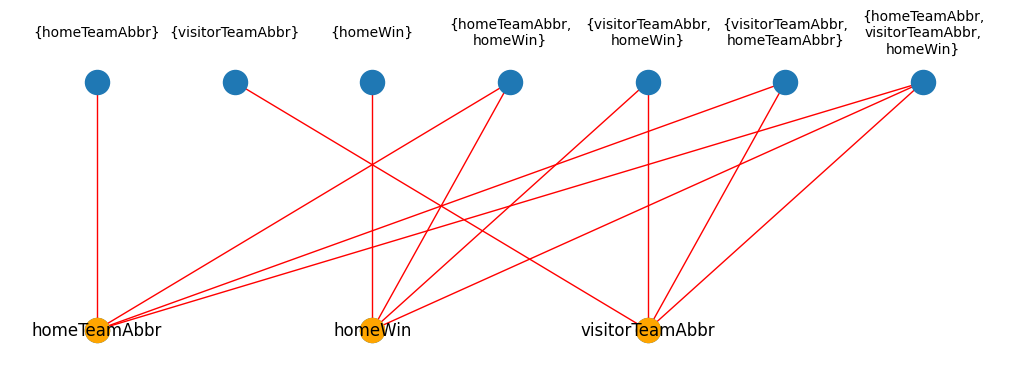

In [5]:
# Print the structure of the Graph to verify its correctness.

plt.figure(figsize=(10, 3))
top = {team: (i * 2, 0) for i, team in enumerate(sorted(nodes))}
bottom = {factor: (i, 1) for i, factor in enumerate(factors)}
# Draw all the variables & factors with their edges.
nx.draw(
    G,
    pos={**top, **bottom},
    edge_color="red",
)
# Draw text labels for the factors above their nodes in the graph.
label_dict = {factor: "{" + ",\n".join(factor.scope()) + "}" for factor in G.factors}
for node, (x, y) in bottom.items():
    plt.text(x, y * 1.2, label_dict[node], fontsize=10, ha="center", va="center")
# Re-draw the variables but with labels this time and colored orange.
nx.draw(
    G.subgraph(nodes),
    node_color="orange",
    pos={**top},
    with_labels=True,
)
plt.show()

### Step 2: Define a model using `MirrorDescentEstimator`

In [6]:
# Initialize model
estimator = MirrorDescentEstimator(model=G, data=games)
marginals = [tuple(i.scope()) for i in G.factors]
observed_factor_dict = FactorDict.from_dataframe(df=games, marginals=marginals)

### Step 3: Learn the marginals 

In [7]:
%%time
_ = estimator.estimate(
    marginals=marginals, metric="L2", iterations=30_000, min_belief=1e-9
)

  0%|          | 0/30000 [00:00<?, ?it/s]

CPU times: user 20.2 s, sys: 2.92 s, total: 23.1 s
Wall time: 23.1 s


### Step 4: View the true marginals against estimated marginals

In [8]:
tree = estimator.belief_propagation.junction_tree
modeled_factor = tree.factors[0]

In [9]:
# Compare a one-way marginal against a modeled clique.
print("Observed")
print(observed_factor_dict[("homeWin",)])
print("\nModeled")
print(modeled_factor.marginalize(["homeTeamAbbr", "visitorTeamAbbr"], inplace=False))

Observed
+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0000 |
+---------------+----------------+
| homeWin(win)  |       159.0000 |
+---------------+----------------+

Modeled
+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |       123.0520 |
+---------------+----------------+
| homeWin(win)  |       159.0270 |
+---------------+----------------+


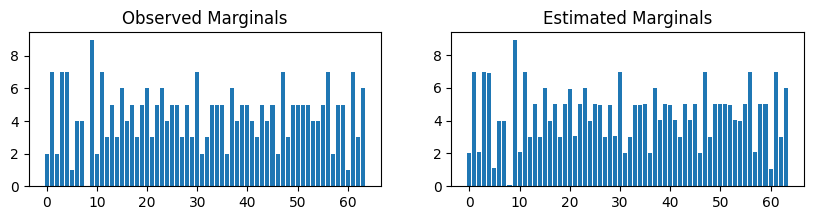

In [10]:
# Compare a larger clique against the true marginals.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))
visitorTeamAbbr_homeWin_marginal = observed_factor_dict[("visitorTeamAbbr", "homeWin")]
total_states = np.prod(visitorTeamAbbr_homeWin_marginal.cardinality)
axes[0].bar(
    range(total_states),
    visitorTeamAbbr_homeWin_marginal.values.flatten(),
)
axes[0].set_title("Observed Marginals")
axes[1].bar(
    range(total_states),
    modeled_factor.marginalize(["homeTeamAbbr"], inplace=False).values.flatten(),
)
axes[1].set_title("Estimated Marginals")
plt.show()

In [11]:
# Out of clique inference for a game that has not yet occured.
print("Number of occurences of marginal")
print(
    int(
        observed_factor_dict[("visitorTeamAbbr", "homeTeamAbbr")].get_value(
            visitorTeamAbbr="SF", homeTeamAbbr="BAL"
        )
    )
)
print("Estimated marginal value")
query_factor = BeliefPropagation(tree).query(
    variables=["homeWin"],
    evidence={"homeTeamAbbr": "SF", "visitorTeamAbbr": "BAL"},
    joint=True,
    show_progress=True,
)
print(query_factor)

Number of occurences of marginal
0
Estimated marginal value
+---------------+----------------+
| homeWin       |   phi(homeWin) |
+===============+================+
| homeWin(loss) |         0.8858 |
+---------------+----------------+
| homeWin(win)  |         0.1142 |
+---------------+----------------+


In [12]:
# Confirm the query results by sampling.
df = modeled_factor.sample(5_000_000)
df_query = df.loc[(df.homeTeamAbbr == "SF") & (df.visitorTeamAbbr == "BAL")]
print("Home Loss")
print((df_query.homeWin == "loss").mean())
print("Home Win")
print((df_query.homeWin == "win").mean())

Home Loss
0.8868704092339978
Home Win
0.1131295907660021
